In [0]:
import numpy as np # linear algebra
import tensorflow as tf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import gc

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
lgbm = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_valid.csv')
lgbm2 = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_2_valid.csv')
lgbm3 = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_3_valid.csv')
xgboost = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/xgboost_valid.csv')
xgboost2 = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/xgboost_2_valid.csv')

In [0]:
X_train = pd.merge(lgbm, lgbm2, on=["ID"], how='left')
X_train = pd.merge(X_train, lgbm3, on=["ID"], how='left')
X_train = pd.merge(X_train, xgboost, on=["ID"], how='left')
X_train = pd.merge(X_train, xgboost2, on=["ID"], how='left')
X_train.columns = ["ID","lgbm","lgbm2", "lgbm3","xgboost", "xgboost2"]
X_train = X_train.drop(labels=['ID'],axis=1)
X_train.head()

lgbm     lgbm2     lgbm3   xgboost  xgboost2
0  0.015821  0.013015  0.033584  0.003421  0.010264
1  0.101723  0.100519  0.122313  0.099146  0.123178
2  0.217560  0.227250  0.204283  0.204469  0.213656
3  0.271519  0.291478  0.262606  0.272340  0.268742
4  0.016698  0.000000  0.024756  0.008952  0.004799

In [0]:
lgbm = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_submission.csv')
lgbm2 = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_2_submission.csv')
lgbm3 = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/lgbm_3_submission.csv')
xgboost = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/xgboost_submission.csv')
xgboost2 = pd.read_csv('./gdrive/My Drive/Colab/kaggle/ensembling/xgboost_2_submission.csv')

In [0]:
X_test = pd.merge(lgbm, lgbm2, on=["ID"], how='left')
X_test = pd.merge(X_test, lgbm3, on=["ID"], how='left')
X_test = pd.merge(X_test, xgboost, on=["ID"], how='left')
X_test = pd.merge(X_test, xgboost2, on=["ID"], how='left')
X_test.columns = ["ID","lgbm", "lgbm2","lgbm3", "xgboost", "xgboost2"]
X_test = X_test.drop(labels=['ID'],axis=1)
X_test.head()

lgbm     lgbm2     lgbm3   xgboost  xgboost2
0  0.653850  0.790730  0.756691  0.584061  0.658180
1  0.497098  0.604127  0.311907  0.370291  0.347201
2  1.265377  1.597262  1.103050  1.369639  1.455140
3  0.547113  0.977016  0.429780  0.601994  0.629335
4  1.745747  2.557427  2.294951  3.502721  3.565408

In [0]:
data = pd.read_pickle('./gdrive/My Drive/Colab/kaggle/data.pkl')
Y_train = data[data.date_block_num == 33]['item_cnt_month']
del data
gc.collect()

7

In [0]:
X_train.shape

(238172, 5)

### Linear

In [0]:
#Standardization
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [0]:
# Linear regression
model = LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_train).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('Linear regression validation rmse: ',rmse)
submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/linear_submission.csv', index=False)

Linear regression validation rmse:  0.8868125873715209


In [0]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, Y_train)
clf.score(X_train, Y_train)
Y_pred = clf.predict(X_train).clip(0,20)
Y_test = clf.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('Linear regression validation rmse: ',rmse)
submission = pd.DataFrame({
    "ID": np.arange(Y_test.shape[0]), 
    "item_cnt_month": Y_test
})
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/Ridge_submission.csv', index=False)

Linear regression validation rmse:  0.8868128240126891


### Simple NN

In [0]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

eas = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True) 
#eas_train = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True) 

In [0]:
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
  
  
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=[root_mean_squared_error])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 12)                72        
_________________________________________________________________
dropout_9 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 13        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, Y_train,
                    validation_split = 0.2, 
                    batch_size=32, epochs=12, verbose=1)
                    #callbacks=[eas])

Train on 190537 samples, validate on 47635 samples
Epoch 1/12
190537/190537 [==============================] - 9s 46us/step - loss: 0.7431 - root_mean_squared_error: 0.7431 - val_loss: 0.4856 - val_root_mean_squared_error: 0.4856
Epoch 2/12
190537/190537 [==============================] - 7s 39us/step - loss: 0.7350 - root_mean_squared_error: 0.7350 - val_loss: 0.4868 - val_root_mean_squared_error: 0.4868
Epoch 3/12
190537/190537 [==============================] - 8s 39us/step - loss: 0.7334 - root_mean_squared_error: 0.7334 - val_loss: 0.4904 - val_root_mean_squared_error: 0.4904
Epoch 4/12
190537/190537 [==============================] - 8s 40us/step - loss: 0.7342 - root_mean_squared_error: 0.7342 - val_loss: 0.4908 - val_root_mean_squared_error: 0.4908
Epoch 5/12
190537/190537 [==============================] - 8s 40us/step - loss: 0.7360 - root_mean_squared_error: 0.7360 - val_loss: 0.4888 - val_root_mean_squared_error: 0.4888
Epoch 6/12
190537/190537 [============================

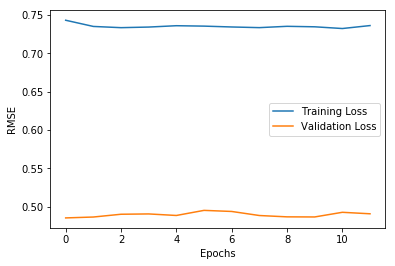

In [0]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [0]:
Y_pred = model.predict(X_train).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('NN validation rmse: ',rmse)
submission = pd.DataFrame(Y_test,columns=['item_cnt_month'])
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/keras_submission.csv',index_label='ID')
submission.tail(10)

NN validation rmse:  0.900125


item_cnt_month
214190        0.046869
214191        0.048489
214192        0.059152
214193        0.081324
214194        0.053723
214195        0.067744
214196        0.051830
214197        0.062056
214198        0.043883
214199        0.053428

### Simple DNN

In [0]:
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
  
  
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=[root_mean_squared_error])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, Y_train,
                    validation_split = 0.2, 
                    batch_size=32, epochs=12, verbose=1)
                    #callbacks=[eas])

Train on 190537 samples, validate on 47635 samples
Epoch 1/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7316 - root_mean_squared_error: 0.7316 - val_loss: 0.4857 - val_root_mean_squared_error: 0.4857
Epoch 2/12
190537/190537 [==============================] - 7s 36us/step - loss: 0.7262 - root_mean_squared_error: 0.7262 - val_loss: 0.4871 - val_root_mean_squared_error: 0.4871
Epoch 3/12
190537/190537 [==============================] - 7s 36us/step - loss: 0.7249 - root_mean_squared_error: 0.7249 - val_loss: 0.4908 - val_root_mean_squared_error: 0.4908
Epoch 4/12
190537/190537 [==============================] - 7s 36us/step - loss: 0.7247 - root_mean_squared_error: 0.7247 - val_loss: 0.4863 - val_root_mean_squared_error: 0.4863
Epoch 5/12
190537/190537 [==============================] - 7s 37us/step - loss: 0.7239 - root_mean_squared_error: 0.7239 - val_loss: 0.4882 - val_root_mean_squared_error: 0.4882
Epoch 6/12
190537/190537 [============================

In [0]:
Y_pred = model.predict(X_train).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('NN validation rmse: ',rmse)
submission = pd.DataFrame(Y_test,columns=['item_cnt_month'])
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/keras_2_submission.csv',index_label='ID')
submission.tail(10)

NN validation rmse:  0.8969941


item_cnt_month
214190        0.007734
214191        0.010772
214192        0.017840
214193        0.042946
214194        0.010417
214195        0.040746
214196        0.009527
214197        0.022460
214198        0.000242
214199        0.016655

### Simple DN Standard Scaler

In [0]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [0]:
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
  
  
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=[root_mean_squared_error])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 12)                72        
_________________________________________________________________
dropout_12 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 13        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, Y_train,
                    validation_split = 0.2, 
                    batch_size=32, epochs=12, verbose=1)
                    #callbacks=[eas])

Train on 190537 samples, validate on 47635 samples
Epoch 1/12
190537/190537 [==============================] - 9s 48us/step - loss: 0.7342 - root_mean_squared_error: 0.7342 - val_loss: 0.4935 - val_root_mean_squared_error: 0.4935
Epoch 2/12
190537/190537 [==============================] - 8s 41us/step - loss: 0.7280 - root_mean_squared_error: 0.7280 - val_loss: 0.4853 - val_root_mean_squared_error: 0.4853
Epoch 3/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7280 - root_mean_squared_error: 0.7280 - val_loss: 0.4831 - val_root_mean_squared_error: 0.4831
Epoch 4/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7291 - root_mean_squared_error: 0.7291 - val_loss: 0.4879 - val_root_mean_squared_error: 0.4879
Epoch 5/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7262 - root_mean_squared_error: 0.7262 - val_loss: 0.4828 - val_root_mean_squared_error: 0.4828
Epoch 6/12
190537/190537 [============================

In [0]:
Y_pred = model.predict(X_train).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('NN validation rmse: ',rmse)
submission = pd.DataFrame(Y_test,columns=['item_cnt_month'])
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/keras_submission_scaled.csv',index_label='ID')
submission.tail(10)

NN validation rmse:  0.89464134


item_cnt_month
214190        0.037069
214191        0.039427
214192        0.049749
214193        0.067386
214194        0.044952
214195        0.060797
214196        0.041766
214197        0.048857
214198        0.033996
214199        0.043100

### Simple DN MinMax Scaler

In [0]:
mc=MinMaxScaler()
X_train=mc.fit_transform(X_train)
X_test=mc.transform(X_test)

In [0]:
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal'))
  
  
model.compile(optimizer="adam", loss=root_mean_squared_error, metrics=[root_mean_squared_error])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 12)                72        
_________________________________________________________________
dropout_13 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 13        
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, Y_train,
                    validation_split = 0.2, 
                    batch_size=32, epochs=12, verbose=1)
                    #callbacks=[eas])

Train on 190537 samples, validate on 47635 samples
Epoch 1/12
190537/190537 [==============================] - 9s 49us/step - loss: 0.7472 - root_mean_squared_error: 0.7472 - val_loss: 0.4874 - val_root_mean_squared_error: 0.4874
Epoch 2/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7306 - root_mean_squared_error: 0.7306 - val_loss: 0.4908 - val_root_mean_squared_error: 0.4908
Epoch 3/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7298 - root_mean_squared_error: 0.7298 - val_loss: 0.4902 - val_root_mean_squared_error: 0.4902
Epoch 4/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7306 - root_mean_squared_error: 0.7306 - val_loss: 0.4876 - val_root_mean_squared_error: 0.4876
Epoch 5/12
190537/190537 [==============================] - 8s 42us/step - loss: 0.7323 - root_mean_squared_error: 0.7323 - val_loss: 0.4886 - val_root_mean_squared_error: 0.4886
Epoch 6/12
190537/190537 [============================

In [0]:
Y_pred = model.predict(X_train).clip(0,20)
Y_test = model.predict(X_test).clip(0,20)
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred))
print('NN validation rmse: ',rmse)
submission = pd.DataFrame(Y_test,columns=['item_cnt_month'])
submission.to_csv('./gdrive/My Drive/Colab/kaggle/ensembling/keras_submission_MMscaled.csv',index_label='ID')
submission.tail(10)

NN validation rmse:  0.9025153


item_cnt_month
214190        0.029370
214191        0.029561
214192        0.030307
214193        0.043264
214194        0.029370
214195        0.047391
214196        0.029370
214197        0.031300
214198        0.029370
214199        0.030317